## Advantages of XGBoost for Classification:
Handling Imbalanced Data: XGBoost has built-in capabilities for handling imbalanced data. It supports the scale_pos_weight parameter, which helps in balancing the positive and negative weights.

Regularization: XGBoost includes L1 (Lasso Regression) and L2 (Ridge Regression) regularization, which can prevent overfitting and improve model generalization.

Robust to Outliers: The model is robust to outliers in the dataset, which can be particularly helpful if your data contains anomalies or noise.

Flexibility: XGBoost can be used for both regression and classification problems and allows for fine-tuning many hyperparameters, offering flexibility to adapt the model to your specific dataset.

Feature Importance: Similar to Random Forest, XGBoost provides feature importance scores, which can be helpful in understanding the predictive power of the input features.

Performance: XGBoost often delivers superior performance and is frequently a winning algorithm in machine learning competitions.

In [52]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer, r2_score, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from pathlib import Path
from sklearn.model_selection import GridSearchCV

In [44]:
current_dir = Path.cwd()
data_dir = current_dir.parent / 'data' / 'processed' 
file_path = data_dir / 'Obesity_data_processed.xlsx'
df = pd.read_excel(file_path, engine='openpyxl')

In [45]:
# Separate target 
y = df['Obese_or_not']

# Drop target from Features DataFrame
X = df.drop('Obese_or_not', axis=1)

In [46]:
ordinal_features = ['Province', 'Sex', 'Marital_status', 'Age', 'Working_12_months', 'Education_level', 
                    'Perceived_life_stress', 'Smoker', 'Drinker_12_months', 'Physical_activity', 
                    'Has_regular_healthcare_provider', 'Immigrant', 'Cultural_racial_background', 
                    'Food_security', 'Personal_income']

feature_orders = {
    'Province': ['NB', 'BC', 'ON', 'QUE', 'MN', 'AB', 'NL', 'PEI', 'NS', 'SASK'],
    "Sex": ["Female", "Male"],
    'Marital_status': ['Single', 'Common-law', 'Widow/Divorced/Sep', 'Married'],
    'Age': ['25 - 29', '20 - 24', '55 - 59', '35 - 39', '60 - 64', '40 - 44', '30 - 34', '50 - 54', '45 - 49'],
    'Working_12_months': ['Yes', 'No'],
    'Education_level': ['Less than secondary school graduation', 'Secondary school graduation only', 'Post-secondary diploma or uni degree'],
    'Perceived_life_stress': ['Not at all stressful', 'Not very stressful', 'A bit stressful', 'Quite a bit stressful', 'Extremely stressful'],
    'Smoker': ['Not at all', 'Occasionally', 'Daily'],
    'Drinker_12_months': ['Did not drink in the last 12 months', 'Occasional drinker', 'Regular drinker'],
    'Physical_activity': ["At/above rec'd level from CPAG", "Below rec'd level from CPAG", 'No physical activity'],
    'Has_regular_healthcare_provider': ['Yes', 'No'],
    'Immigrant': ['Immigrant', 'Canadian born'],
    'Cultural_racial_background': ['White', 'Non-white (other visible minority)', 'Aboriginal'],
    'Food_security': ['Food secure', 'Moderately food insecure', 'Severely food insecure'],
    'Personal_income': ['No income or income loss', 'Less than $20,000', '$20,000 - $39,999', '$40,000 - $59,999', '$60,000 - $79,999', '$80,000 or more']
}

X_ordinal = pd.DataFrame(df[ordinal_features])

categories_order = [feature_orders[feature] for feature in ordinal_features]

encoder = OrdinalEncoder(categories=categories_order)
X_ordinal_encoded = encoder.fit_transform(X_ordinal)
X_ordinal_encoded_df = pd.DataFrame(X_ordinal_encoded, columns=[f'{feat}_encoded' for feat in ordinal_features])

In [47]:
X_ordinal_encoded_df.head(10)

,Province_encoded,Sex_encoded,Marital_status_encoded,Age_encoded,Working_12_months_encoded,Education_level_encoded,Perceived_life_stress_encoded,Smoker_encoded,Drinker_12_months_encoded,Physical_activity_encoded,Has_regular_healthcare_provider_encoded,Immigrant_encoded,Cultural_racial_background_encoded,Food_security_encoded,Personal_income_encoded
0,0.0,0.0,3.0,8.0,0.0,2.0,3.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,2.0
1,1.0,0.0,2.0,7.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,4.0
2,2.0,0.0,3.0,8.0,0.0,2.0,2.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,4.0
3,3.0,0.0,1.0,6.0,1.0,2.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,5.0
4,3.0,0.0,1.0,8.0,0.0,2.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,4.0
5,2.0,0.0,1.0,6.0,0.0,2.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,3.0
6,2.0,0.0,3.0,7.0,0.0,2.0,2.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,1.0
7,1.0,0.0,3.0,5.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0
8,1.0,0.0,2.0,4.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,4.0
9,3.0,1.0,1.0,3.0,0.0,2.0,1.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,4.0


## First Model

In [48]:
# Encode the target as binary, Calculate counts and scale_pos_weight

y_encoded = y.map({'Not obese': 0, 'Obese': 1})

positive_count = sum(y_encoded == 1)
negative_count = sum(y_encoded == 0)

scale_pos_weight = negative_count / positive_count

X_train, X_test, y_train, y_test = train_test_split(X_ordinal_encoded_df, y_encoded, test_size=0.2, random_state=42)

In [49]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight,
    random_state=42)

xgb_clf.fit(X_train, y_train)  

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Accuracy: 0.6065331582403152
ROC AUC Score: 0.6320080697118259
              precision    recall  f1-score   support

           0       0.76      0.62      0.68      8356
           1       0.41      0.57      0.48      3828

    accuracy                           0.61     12184
   macro avg       0.58      0.60      0.58     12184
weighted avg       0.65      0.61      0.62     12184



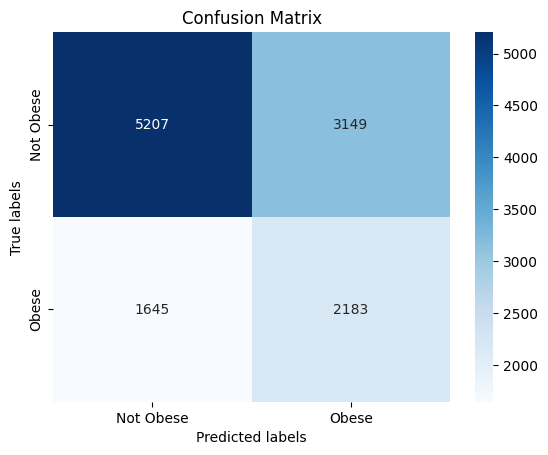

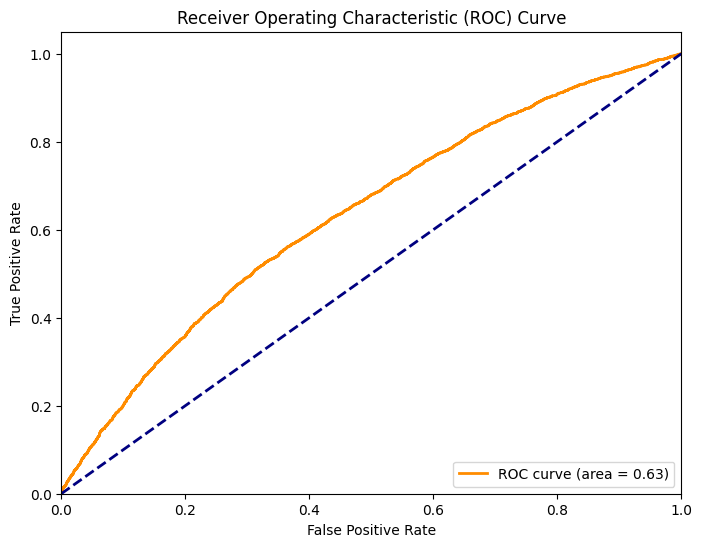

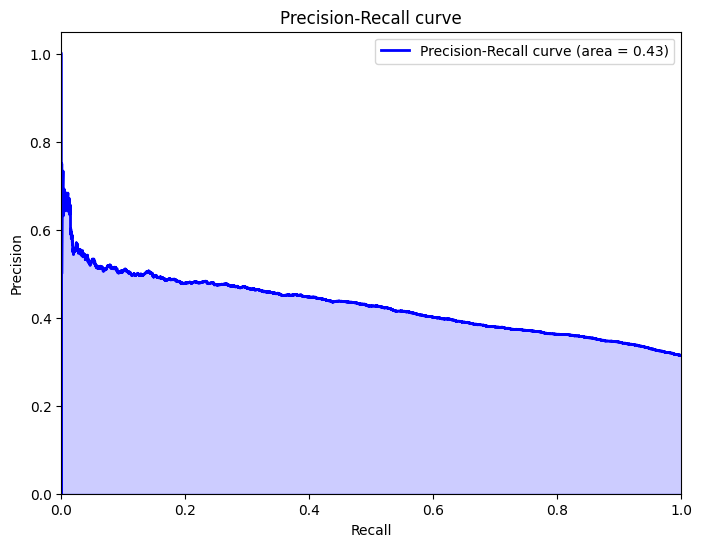

In [53]:
y_pred = xgb_clf.predict(X_test)
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]  

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Not Obese', 'Obese'], yticklabels=['Not Obese', 'Obese'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

#ROC curve

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc="upper right")
plt.show()

## Interpretation:

Accuracy (60.65%): This metric shows the overall percentage of correct predictions. Good.

ROC AUC Score (63.20%): The Area Under the Receiver Operating Characteristic Curve is a better indicator of model performance in cases of class imbalance. A score of 63.20% is decent but not great

Precision and Recall:

For the majority class (0 or 'Not obese') the precision is relatively high (76%) but the recall is lower (62%) indicating that while the model is good at identifying 'Not obese' cases it's missing a significant number of them.

F1-Score:

The F1-score for 'Not obese' is 0.68, and for 'Obese', it's 0.48.

## Feature Importance for XGBOOST

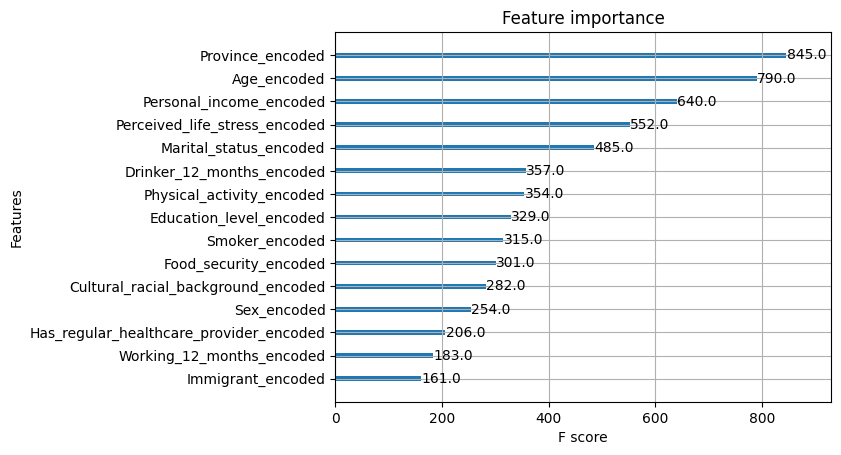

In [22]:
xgb.plot_importance(xgb_clf)  
plt.show()

## Hyperparemeter Tuning:

In [39]:
param_grid = {
    'max_depth': [3, 4, 5, 6],  
    'min_child_weight': [1, 2, 3],  
    'gamma': [0, 0.1, 0.2],  
    'subsample': [0.8, 0.9, 1.0],  
    'colsample_bytree': [0.8, 0.9, 1.0],  
    'n_estimators': [100, 200],  
    'learning_rate': [0.01, 0.1, 0.2]}

In [40]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, objective='binary:logistic', eval_metric='logloss', random_state=42)

grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='roc_auc')

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1944 candidates, totalling 5832 fits


KeyboardInterrupt: 

In [25]:
print("Best parameters:", grid_search.best_params_)
print("Best ROC AUC Score:", grid_search.best_score_)
best_model = grid_search.best_estimator_

Best parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}
Best ROC AUC Score: 0.6504753617187532


In [26]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_best))
print(classification_report(y_test, y_pred_best))

ROC AUC Score: 0.6547096599443869
              precision    recall  f1-score   support

           0       0.70      0.96      0.81      8356
           1       0.58      0.11      0.19      3828

    accuracy                           0.70     12184
   macro avg       0.64      0.54      0.50     12184
weighted avg       0.66      0.70      0.62     12184



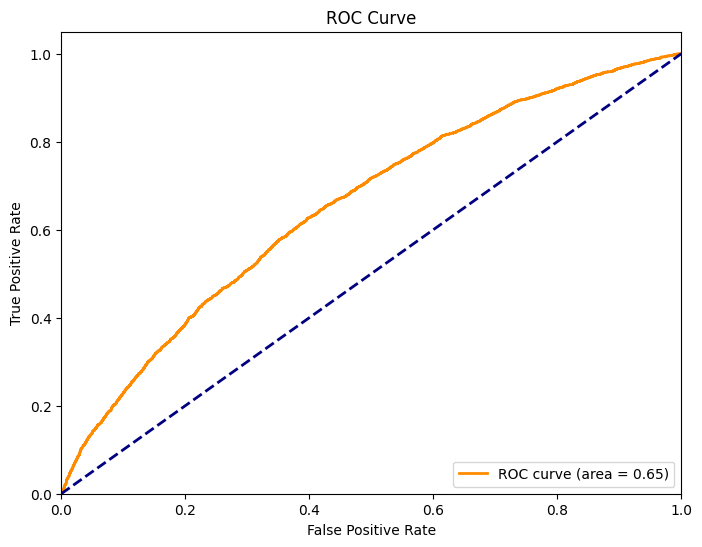

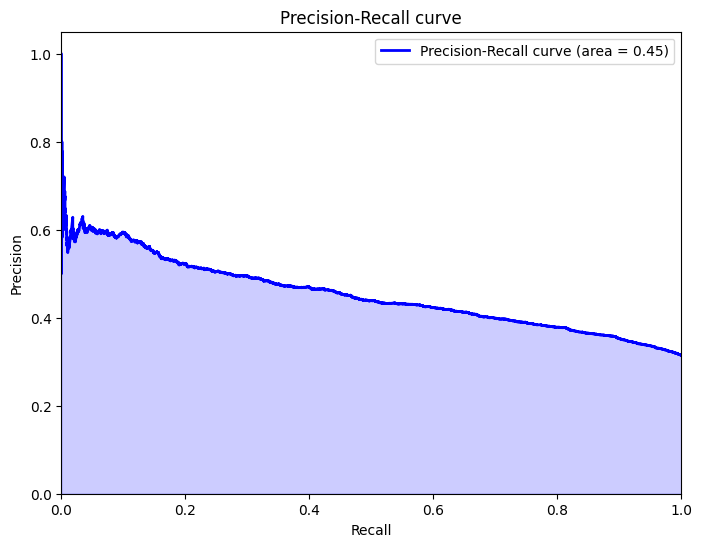

In [42]:
from sklearn.metrics import precision_recall_curve, average_precision_score

fpr, tpr, _ = roc_curve(y_test, y_pred_proba_best)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_best)
average_precision = average_precision_score(y_test, y_pred_proba_best)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc="upper right")
plt.show()

## Evaluation metrics:

Accuracy:
The accuracy of 0.70 is good. 

ROC AUC Score:
The ROC AUC Score of 0.6547 is an improvement over previous models. This metric suggests the model has a decent ability to distinguish between the 'Obese' and 'Not obese' classes. A higher ROC AUC indicates the model is better at ranking predictions correctly.

Precision, Recall, and F1-Score:
Precision for 'Not obese' (0) is relatively high at 0.70, indicating that when the model predicts an instance is not obese, it is correct 70% of the time. However, the precision for 'Obese' (1) drops to 0.58, showing a reduction in accuracy when predicting the minority class.

Recall for 'Not obese' is very high at 0.96, which means the model is very effective at identifying the majority class. However, recall for 'Obese' is significantly lower at 0.11, indicating that the model struggles to identify most of the true 'Obese' cases, missing out on 89% of them.

F1-Scores:
Balance precision and recall, highlight a significant issue - while the model performs well on the 'Not obese' class (0.81), it performs poorly on the 'Obese' class (0.19). Means the model is biased towards the majority class and struggles with the imbalanced nature of the dataset.


## Combination of SMOTE and Adjusting the Decision Threshold:
- To deal with imbalance problem. (It doesn't work, it just makes it worse).


In [27]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

xgb_clf.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [29]:
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [31]:
y_scores = xgb_clf.predict_proba(X_val)[:, 1] 
precision, recall, thresholds = precision_recall_curve(y_val, y_scores, pos_label=1)

criterion = precision[:-1] + recall[:-1]  
max_index = np.argmax(criterion)
threshold_optimal = thresholds[max_index]

print(f"Optimal Threshold: {threshold_optimal}")

y_pred_optimal = (y_scores >= threshold_optimal).astype(int)

Optimal Threshold: 0.16318382322788239


## Apply the Optimal Threshold:

In [35]:
from sklearn.metrics import classification_report, accuracy_score

print("Validation setperformance:")
print("accuracy:", accuracy_score(y_val, y_pred_optimal))
print(classification_report(y_val, y_pred_optimal))

Validation setperformance:
accuracy: 0.411879359868691
              precision    recall  f1-score   support

           0       0.93      0.16      0.27      6740
           1       0.34      0.97      0.51      3008

    accuracy                           0.41      9748
   macro avg       0.64      0.57      0.39      9748
weighted avg       0.75      0.41      0.35      9748



In [36]:
y_scores_test = xgb_clf.predict_proba(X_test)[:, 1] 
y_pred_optimal_test = (y_scores_test >= threshold_optimal).astype(int)

print("Test set performance:")
print("accuracy :", accuracy_score(y_test, y_pred_optimal_test))
print(classification_report(y_test, y_pred_optimal_test))

Test set performance:
accuracy : 0.39650361129349965
              precision    recall  f1-score   support

           0       0.84      0.15      0.25      8356
           1       0.34      0.94      0.49      3828

    accuracy                           0.40     12184
   macro avg       0.59      0.54      0.37     12184
weighted avg       0.68      0.40      0.33     12184



## Results:
- It's getting worse. I should stop now.

# Save Model 

In [ ]:
#If later want to save Model whens satisfied:

# import joblib

# # Save the model to a file
# joblib.dump(xgb_clf, 'xgb_model.pkl')

# # Load the model from the file (when needed)
# xgb_clf_loaded = joblib.load('xgb_model.pkl')